<a href="https://colab.research.google.com/github/sahilfaizal01/Two-Stage-Brain-Tumor-Recognition-and-Identification/blob/main/Combined_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
# Load pretrained model (instead of training the model for 1+ hours) 
with open('/content/drive/MyDrive/Brain-Tumor-Segmentation/classifier-Densenet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/MyDrive/Brain-Tumor-Segmentation/best-classifier-densenet121-weights.h5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [35]:
from utilities import focal_tversky, tversky_loss, tversky

with open('/content/drive/MyDrive/Brain-Tumor-Segmentation/ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('/content/drive/MyDrive/Brain-Tumor-Segmentation/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Brain-Tumor-Segmentation/Brain_MRI/data_mask.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [38]:
# Drop the patient id column
brain_df_train = df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [39]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [40]:
%cd /content/drive/MyDrive/Brain-Tumor-Segmentation/Brain_MRI/

/content/drive/MyDrive/Brain-Tumor-Segmentation/Brain_MRI


In [41]:
brain_df_train.head()

,image_path,mask_path,mask
0,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [42]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.25)

In [43]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 196ms/step


In [44]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20...,"[[[[8.1767195e-07], [3.039987e-06], [6.081936e...",1
1,TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_13...,No mask,0
2,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_21...,No mask,0
3,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50...,No mask,0
4,TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_1.tif,No mask,0
...,...,...,...
978,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_8.tif,No mask,0
979,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_12...,"[[[[6.167054e-07], [2.3413224e-06], [4.8337947...",1
980,TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_14...,No mask,0
981,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_45...,No mask,0


In [45]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20...,TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20...,1,"[[[[8.1767195e-07], [3.039987e-06], [6.081936e...",1
1,TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_13...,TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_13...,0,No mask,0
2,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_21...,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_21...,0,No mask,0
3,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50...,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50...,1,No mask,0
4,TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_1.tif,TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_1_...,0,No mask,0


In [46]:
import matplotlib.pyplot as plt
import cv2
from skimage import io
import numpy as np

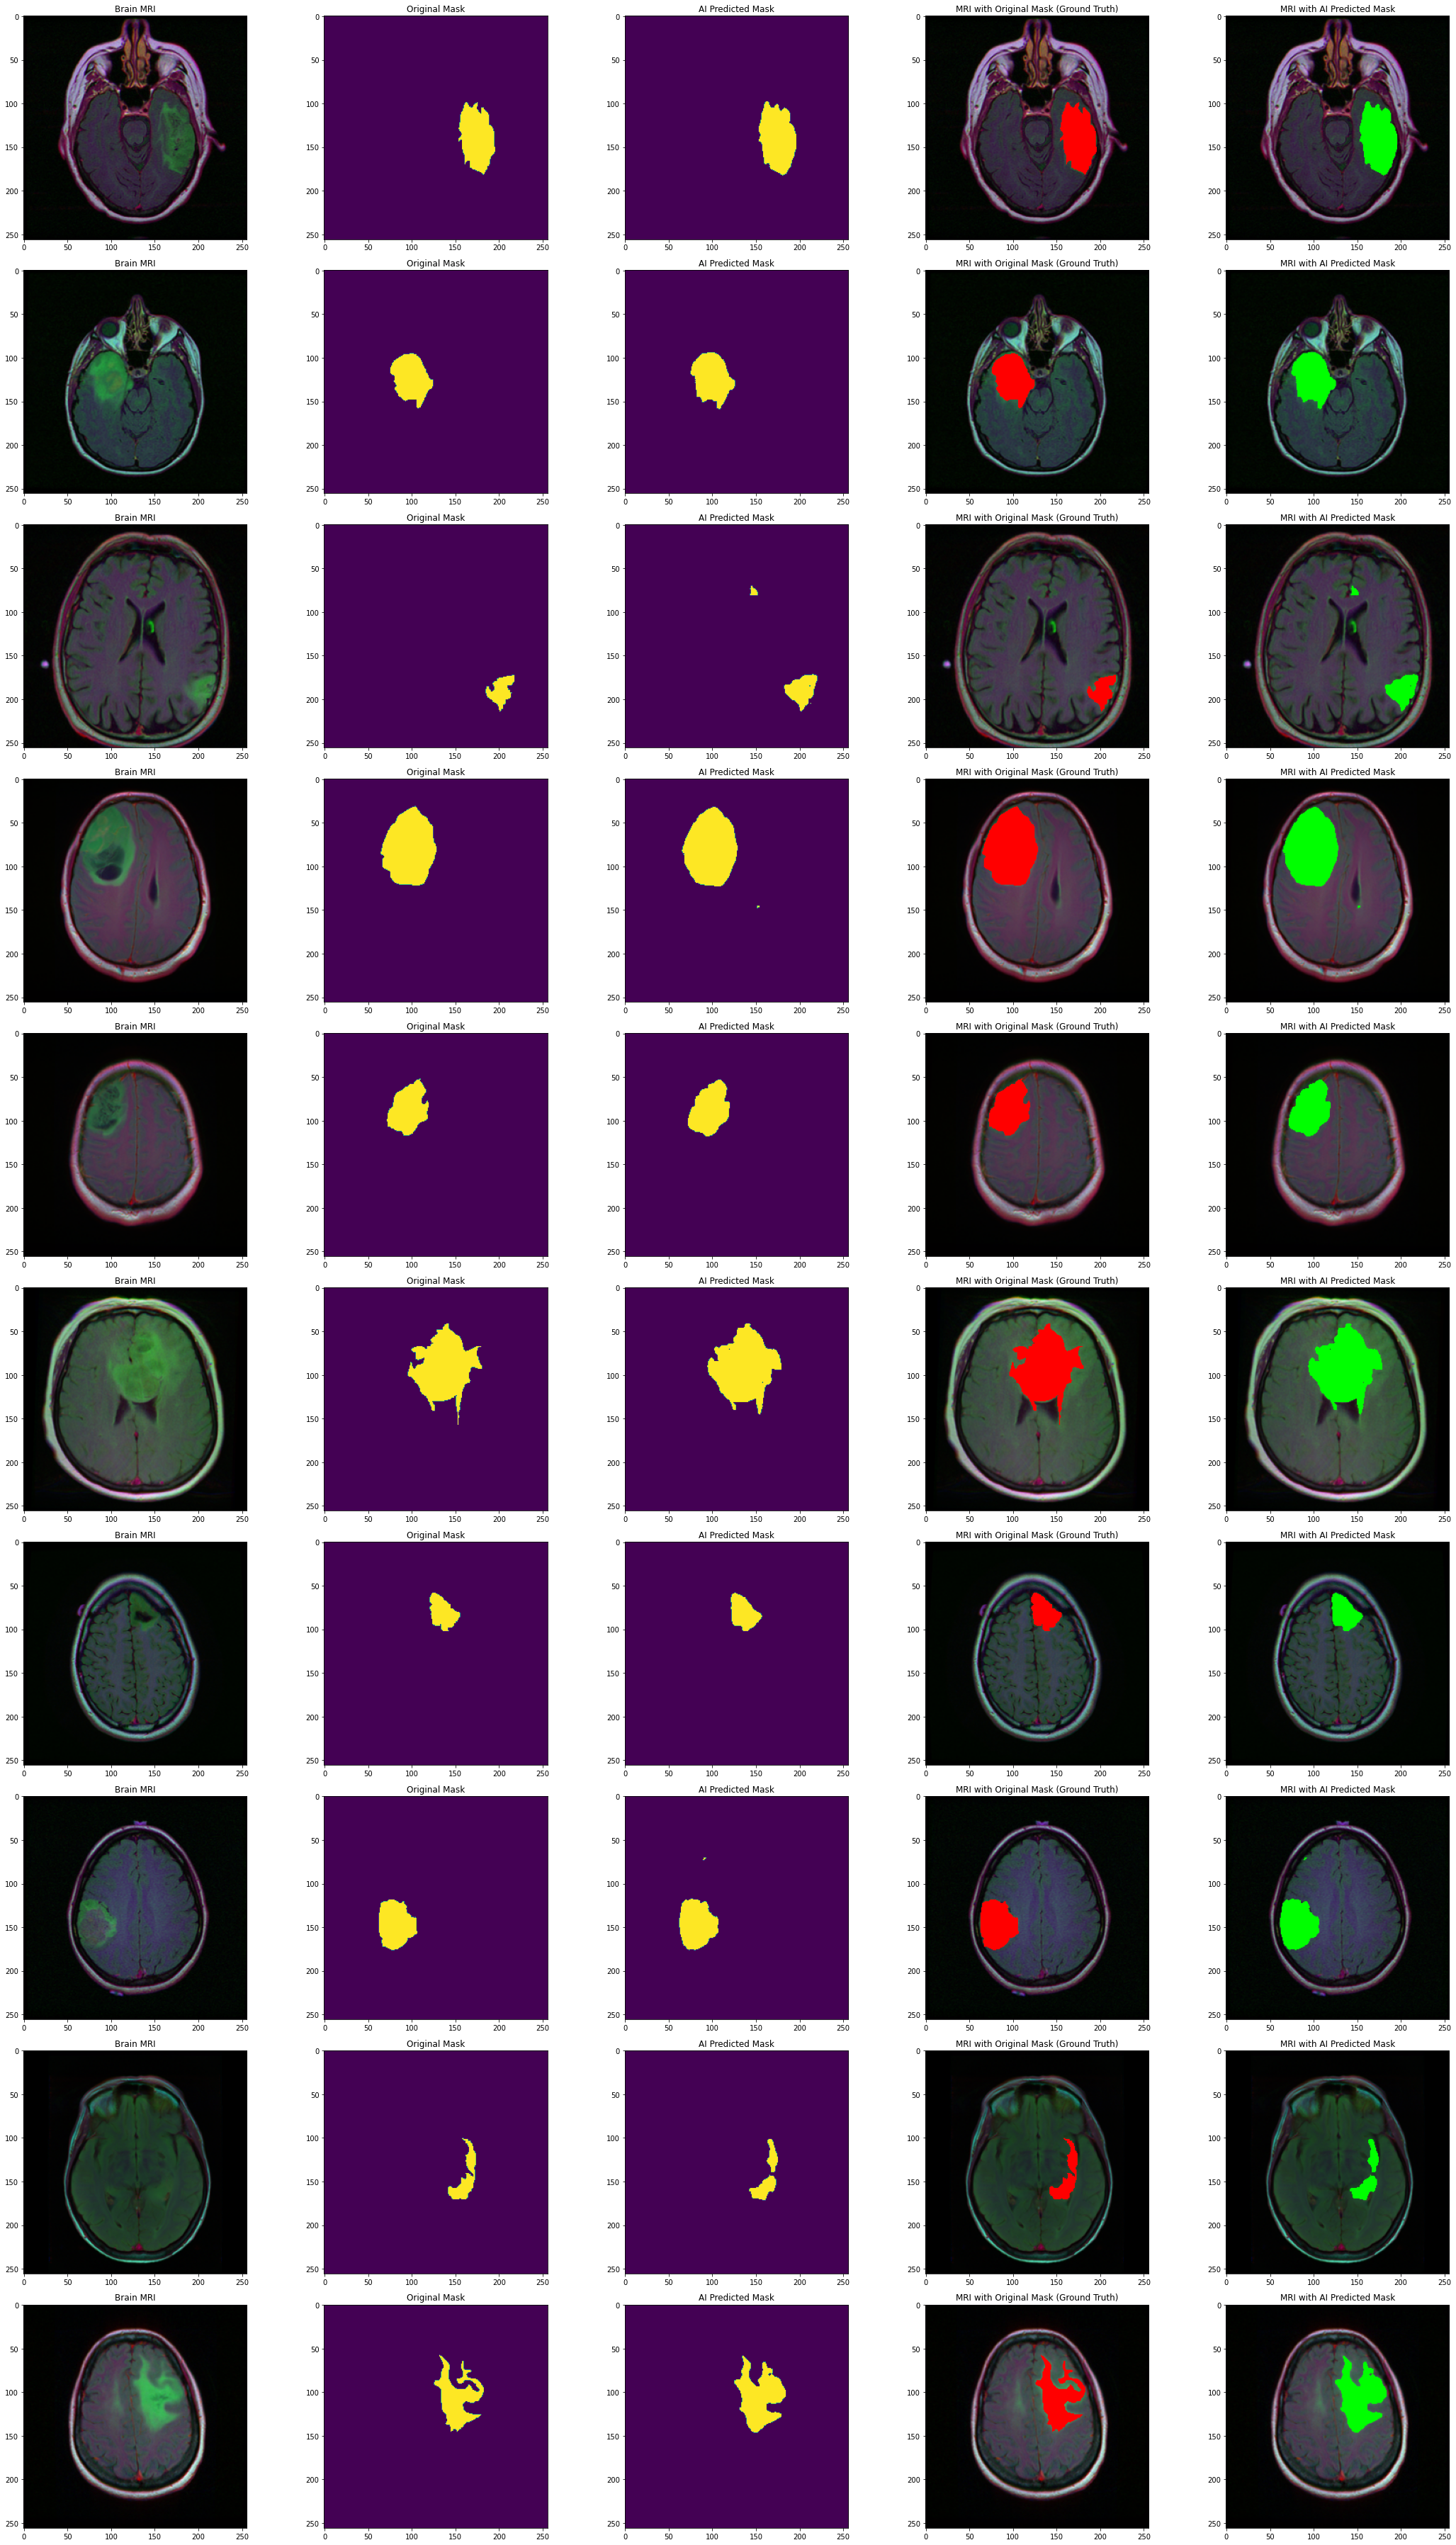

In [47]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()